# Markov chain Monte Carlo (MCMC) sampling, part 1: the basics

[Markov chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) is a powerful class of methods to sample from probability distributions known only up to an (unknown) normalization constant. But before we dive into MCMC, let's consider why you might want to do sampling in the first place.

The answer to that is: whenever you're either interested in the samples themselves (for example, inferring unknown parameters in Bayesian inference) or you need them to approximate expected values of functions w.r.t. to a probability distribution (for example, calculating thermodynamic quantities from the distribution of microstates in statistical physics). Sometimes, only the mode of a probability distribution is of primary interest. In this case, it's obtained by numerical optimization so full sampling is not necessary.

It turns out that sampling from any but the most basic probability distributions is a difficult task. [Inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) is an elementary method to sample from probability distributions, but requires the cumulative distribution function, which in turn requires knowledge of the, generally unknown, normalization constant. Now in principle, you could just obtain the normalization constant by numerical integration, but this quickly gets infeasible with an increasing number of dimensions. [Rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling) does not require a normalized distribution, but efficiently implementing it requires a good deal of knowledge about the distribution of interest, and it suffers strongly from the curse of dimension, meaning that its efficiency decreases rapidly with an increasing number of variables. That's when you need a smart way to obtain representative samples from your distribution which doesn't require knowledge of the normalization constant.

MCMC algorithms are a class of methods which do exactly that. These methods date back to a [seminal paper by Metropolis et al.](https://pdfs.semanticscholar.org/7b3d/c9438227f747e770a6fb6d7d7c01d98725d6.pdf), who developed the first MCMC algorithm, correspondingly called [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), to calculate the equation of state of a two-dimensional system of hard spheres. In reality, they were looking for a general method to calculate expected values occurring in statistical physics.

In this blog post, I introduce the basics of MCMC sampling; in subsequent posts I'll cover several important, increasingly complex and powerful MCMC algorithms, which all address different difficulties one frequently faces when using the Metropolis-Hastings algorithm. Along the way, you will gain a solid understanding of these challenges and how to address them. Also, this serves as a reference for MCMC methods in the context of the [monad-bayes](https://www.tweag.io/posts/2019-09-20-monad-bayes-1.html) series. Furthermore, I hope the provided notebooks will not only spark your interest in exploring the behavior of MCMC algorithms for various parameters/probability distributions, but also serve as a basis for implementing and understanding useful extensions of the basic versions of the algorithms I present.

## Markov chains

Now that we know why we want to sample, let's get to the heart of MCMC &mdash; Markov chains.
What is a Markov chain?
Without all the technical details, a Markov chain is a random sequence of states in some state space in which the probability of picking a certain state next depends only on the current state in the chain and not on the previous history: it is memory-less.
Under certain conditions, a Markov chain has a unique stationary distribution of states to which it will converge after a certain number of states.
From that number on, states in the Markov chain will be distributed according to the invariant distribution.
MCMC algorithms work by constructing a Markov chain with the probability distribution you want to sample from as the stationary distribution.
In order to sample from a distribution $\pi(x)$, a MCMC algorithm constructs and simulates a Markov chain whose stationary distribution is $\pi(x)$, meaning that, after an initial "burn-in" phase, the states of that Markov chain are distributed according to $\pi(x)$. We thus just have to store the states to obtain samples from $\pi(x)$.

For didactic purposes, let's for now consider both a discrete state space and discrete "time".
The key quantity characterizing a Markov chain is the transition operator $T(x_{i+1}|x_i)$ which gives you the probability of being in state $x_{i+1}$ at time $i+1$ given that the chain is in state $x_i$ at time $i$.

Now just for fun (and for illustration), let's quickly whip up a Markov chain which has a unique stationary distribution. We'll start with some imports and settings for the plots:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

The Markov chain will hop around on a discrete state space which is made up from three weather states:

In [3]:
state_space = ("sunny", "cloudy", "rainy")

In a discrete state space, the transition operator is just a matrix.
Columns and rows correspond, in our case, to sunny, cloudy, and rainy weather.
We pick more or less sensible values for all transition probabilities:

In [4]:
transition_matrix = np.array(((0.6, 0.3, 0.1),
                              (0.3, 0.4, 0.3),
                              (0.2, 0.3, 0.5)))

The rows indicate the states the chain might currently be in and the columns the states the chains might transition to.
If we take one "time" step of the Markov chain as one hour, then, if it's sunny, there's a 60% chance it stays sunny in the next hour, a 30% chance that in the next hour we will have cloudy weather and only a 10% chance of rain immediately after it had been sunny before.
This also means that each row has to sum up to one.

Let's run our Markov chain for a while:

In [5]:
n_steps = 20000
states = [0]
for i in range(n_steps):
    states.append(np.random.choice((0, 1, 2), p=transition_matrix[states[-1]]))
states = np.array(states)

We can monitor the convergence of our Markov chain to its stationary distribution by calculating the empirical probability for each of the states as a function of chain length:

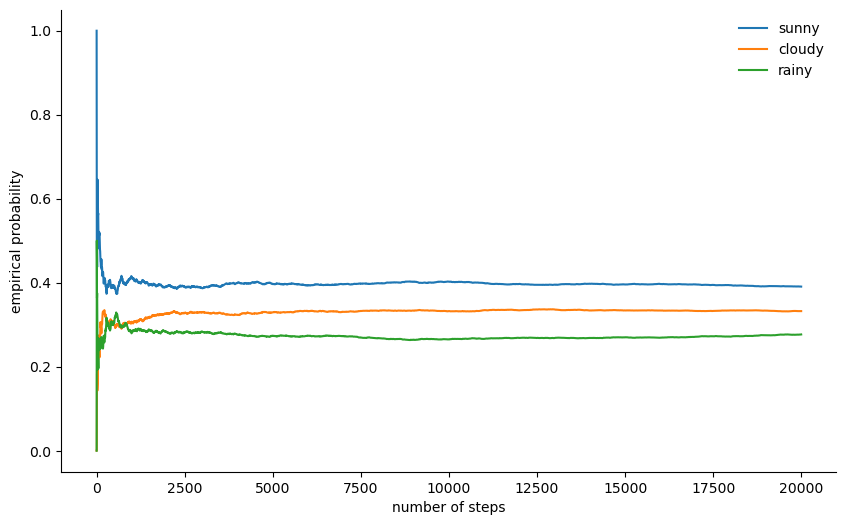

In [6]:
def despine(ax, spines=('top', 'left', 'right')):
    for spine in spines:
        ax.spines[spine].set_visible(False)

fig, ax = plt.subplots()
width = 1000
offsets = range(1, n_steps, 5)
for i, label in enumerate(state_space):
    ax.plot(offsets, [np.sum(states[:offset] == i) / offset 
            for offset in offsets], label=label)
ax.set_xlabel("number of steps")
ax.set_ylabel("empirical probability")
ax.legend(frameon=False)
despine(ax, ('top', 'right'))
plt.show()

## The mother of all MCMC algorithms: Metropolis-Hastings

So that's lots of fun, but back to sampling an arbitrary probability distribution $\pi$. 
It could either be discrete, in which case we would keep talking about a transition matrix $T$, or it continous, in which case $T$ would be a transition *kernel*.
From now on, we're considering continuous distributions, but all concepts presented here transfer to the discrete case.  
If we could design the transition kernel in such a way that the next state is already drawn from $\pi$, we would be done, as our Markov Chain would... well...  immediately sample from $\pi$.
Unfortunately, to do this, we need to be able to sample from $\pi$, which we can't.
Otherwise you wouldn't be reading this, right?  
A way around this is to split the transition kernel $T(x_{i+1}|x_i)$ into two parts:
a proposal step and an acceptance/rejection step. The proposal step features a proposal distribution $q(x_{i+1}|x_i)$, from which we can sample possible next states of the chain. In addition to being able to sample from it, we can choose this distribution arbitrarily. But, one should strive to design it such that samples from it are both as little correlated with the current state as possible and have a good chance of being accepted in the acceptance step. Said acceptance/rejection step is the second part of the transition kernel and corrects for the error introduced by proposal states drawn from $q \neq \pi$. It involves calculating an acceptance probability $p_\mathrm{acc}(x_{i+1}|x_i)$ and accepting the proposal $x_{i+1}$ with that probability as the next state in the chain. Drawing the next state $x_{i+1}$ from $T(x_{i+1}|x_i)$ is then done as follows: first, a proposal state $x_{i+1}$ is drawn from $q(x_{i+1}|x_i)$. It is then accepted as the next state with probability 
$p_\mathrm{acc}(x_{i+1}|x_i)$ or rejected with probability $1 - p_\mathrm{acc}(x_{i+1}|x_i)$, in which case the current state is copied as the next state.

We thus have 
$$
T(x_{i+1}|x_i)=q(x_{i+1} | x_i) \times p_\mathrm{acc}(x_{i+1}|x_i)
$$
A sufficient condition for a Markov chain to have $\pi$ as its stationary distribution is the transition kernel obeying *detailed balance* or, in the physics literature, *microscopic reversibility*:
$$
\pi(x_i) T(x_{i+1}|x_i) = \pi(x_{i+1}) T(x_i|x_{i+1})
$$
This means that the probability of being in a state $x_i$ and transitioning to $x_{i+1}$ must be equal to the probability of the reverse process, namely, being in state $x_{i+1}$ and transitioning to $x_i$.
Transition kernels of most MCMC algorithms satisfy this condition.   
For the two-part transition kernel to obey detailed balance, we need to choose $p_\mathrm{acc}$ correctly, meaning that is has to correct for any asymmetries in probability flow from / to $x_{i+1}$ or $x_i$.
One possibility is the Metropolis acceptance criterion: 
$$
p_\mathrm{acc}(x_{i+1}|x_i) = \mathrm{min} \left\{1, \frac{\pi(x_{i+1}) \times q(x_i|x_{i+1})}{\pi(x_i) \times q(x_{i+1}|x_i)} \right\} \
$$
Now here's where the magic happens: we know $\pi$ only up to a constant, but it doesn't matter, because that unknown constant cancels out in the expression for $p_\mathrm{acc}$! It is this property of $p_\mathrm{acc}$ which makes algorithms based on Metropolis-Hastings work for unnormalized distributions. Often, symmetric proposal distributions with $q(x_i|x_{i+1})=q(x_{i+1}|x_i)$ are used, in which case the Metropolis-Hastings algorithm reduces to the original, but less general Metropolis algorithm developed in 1953 and for which
$$
p_\mathrm{acc}(x_{i+1}|x_i) = \mathrm{min} \left\{1, \frac{\pi(x_{i+1})}{\pi(x_i)} \right\} \ .
$$
We can then write the complete Metropolis-Hastings transition kernel as
$$
T(x_{i+1}|x_i) = \begin{cases}
                   q(x_{i+1}|x_i) \times p_\mathrm{acc}(x_{i+1}|x_i) &: x_{i+1} \neq x_i ; \\
                   1 - \int \mathrm{d}x_{i+1} \ q(x_{i+1}|x_i) \times p_\mathrm{acc}(x_{i+1}|x_i) &: x_{i+1} = x_i .
                 \end{cases} 
$$

## Implementing the Metropolis-Hastings algorithm in Python

All right, now that we know how Metropolis-Hastings works, let's go ahead and implement it.
First, we set the log-probability of the distribution we want to sample from - without normalization constants, as we pretend we don't know them.
Let's work for now with a standard normal distribution:

In [23]:
def log_prob(x):
     return -0.5 * np.sum(x ** 2)

Next, we choose a symmetric proposal distribution.
Generally, including information you have about the distribution you want to sample from in the proposal distribution will lead to better performance of the Metropolis-Hastings algorithm. 
A naive approach is to just take the current state $x$ and pick a proposal from $\mathcal{U}(x-\frac{\Delta}{2}, x+\frac{\Delta}{2})$, that is, we set some step size $\Delta$ and move left or right a maximum of $\frac{\Delta}{2}$ from our current state:

In [24]:
def proposal(x, stepsize):
    return np.random.uniform(low=x - 0.5 * stepsize, 
                             high=x + 0.5 * stepsize, 
                             size=x.shape)

Finally, we calculate our acceptance probability:

In [25]:
def p_acc_MH(x_new, x_old, log_prob):
    return min(1, np.exp(log_prob(x_new) - log_prob(x_old)))

Now we piece all this together into our really brief implementation of a Metropolis-Hastings sampling step:

In [26]:
def sample_MH(x_old, log_prob, stepsize):
    x_new = proposal(x_old, stepsize)
    # here we determine whether we accept the new state or not:
    # we draw a random number uniformly from [0,1] and compare
    # it with the acceptance probability
    accept = np.random.random() < p_acc_MH(x_new, x_old, log_prob)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

Apart from the next state in the Markov chain, `x_new` or `x_old`, we also return whether the MCMC move was accepted or not.
This will allow us to keep track of the acceptance rate.
Let's complete our implementation by writing a function that iteratively calls `sample_MH` and thus builds up the Markov chain:

In [27]:
def build_MH_chain(init, stepsize, n_total, log_prob):

    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_MH(chain[-1], log_prob, stepsize)
        chain.append(state)
        n_accepted += accept
    
    acceptance_rate = n_accepted / float(n_total)
    
    return chain, acceptance_rate

## Testing our Metropolis-Hastings implementation and exploring its behavior

Now you're probably excited to see this in action.
Here we go, taking some informed guesses at the `stepsize` and `n_total` arguments:

In [28]:
chain, acceptance_rate = build_MH_chain(np.array([2.0]), 3.0, 10000, log_prob)
chain = [state for state, in chain]
print("Acceptance rate: {:.3f}".format(acceptance_rate))
last_states = ", ".join("{:.5f}".format(state) 
                        for state in chain[-10:])
print("Last ten states of chain: " + last_states)

Acceptance rate: 0.711
Last ten states of chain: -0.50438, -0.53612, -1.21488, -0.38176, -0.71088, -0.26027, -0.26027, 0.35513, -0.02099, -0.02099


All right.
So did this work?
We achieved an acceptance rate of around 71% and we have a chain of states.
We should throw away the first few states during which the chain won't have converged to its stationary distribution yet.
Let's check whether the states we drew are actually normally distributed:

10001


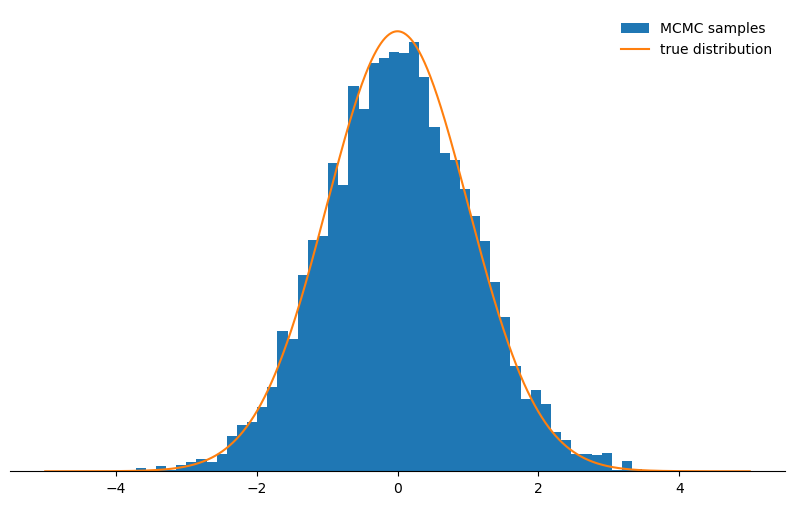

In [ ]:
def plot_samples(chain, log_prob, ax, orientation='vertical', normalize=True,
                 xlims=(-5, 5), legend=True):
    from scipy.integrate import quad
    
    ax.hist(chain, bins=50, density=True, label="MCMC samples",
           orientation=orientation)
    # we numerically calculate the normalization constant of our PDF
    if normalize:
        Z, _ = quad(lambda x: np.exp(log_prob(x)), -np.inf, np.inf)
    else:
        Z = 1.0
    xses = np.linspace(xlims[0], xlims[1], 1000)
    yses = [np.exp(log_prob(x)) / Z for x in xses]
    if orientation == 'horizontal':
        (yses, xses) = (xses, yses)
    ax.plot(xses, yses, label="true distribution")
    if legend:
        ax.legend(frameon=False)

fig, ax = plt.subplots()
# we discard the first 500 samples as burn-in
plot_samples(chain[500:], log_prob, ax)
despine(ax)
ax.set_yticks(())
plt.show()

Looks great!

Now, what's up with the parameters `stepsize` and `n_total`?
We'll discuss the step size first: it determines how far away a proposal state can be from the current state of the chain. It is thus a parameter of the proposal distribution $q$ and controls how big the random steps are which the Markov chain takes. If the step size is too large, the proposal state will often be in the tails of the distribution, where probability is low.
The Metropolis-Hastings sampler rejects most of these moves, meaning that the acceptance rate decreases and convergence is much slower.
See for yourself:

Acceptance rate: 0.106


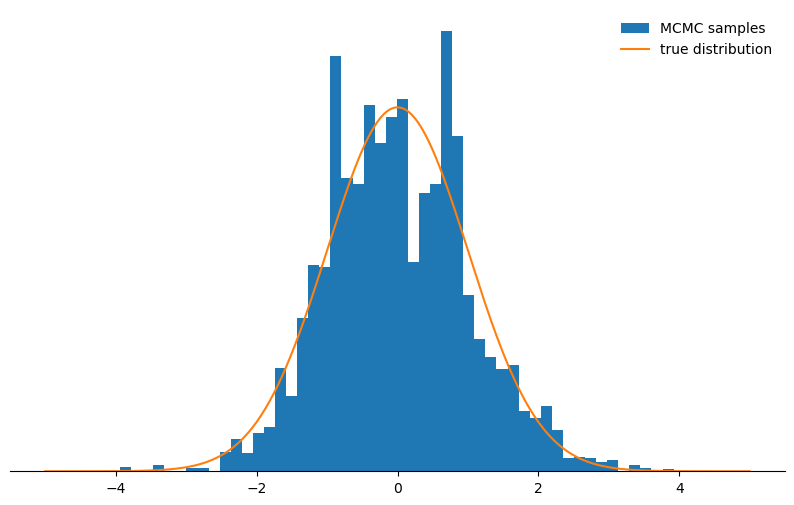

In [37]:
def sample_and_display(init_state, stepsize, n_total, n_burnin, log_prob):
    chain, acceptance_rate = build_MH_chain(init_state, stepsize, n_total, log_prob)
    print("Acceptance rate: {:.3f}".format(acceptance_rate))
    fig, ax = plt.subplots()
    plot_samples([state for state, in chain[n_burnin:]], log_prob, ax)
    despine(ax)
    ax.set_yticks(())
    plt.show()
    
sample_and_display(np.array([2.0]), 30, 10000, 500, log_prob)

Not as cool, right?
Now you could think the best thing to do is do choose a tiny step size.
Turns out that this is not too smart either because then the Markov chain will explore the probability distribution only very slowly and thus again won't converge as rapidly as with a well-adjusted step size:

Acceptance rate: 0.990


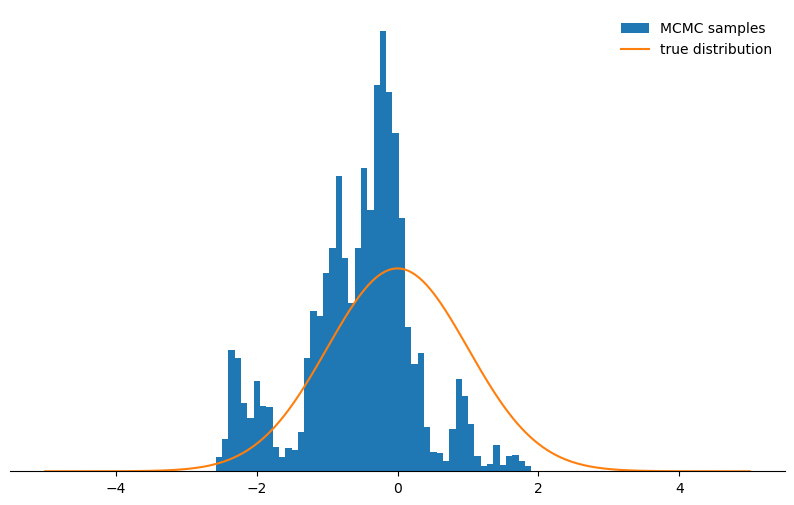

In [42]:
sample_and_display(np.array([2.0]), 0.1, 10000, 500, log_prob)

No matter how you choose the step size parameter, the Markov chain will eventually converge to its stationary distribution.
But it may take a looooong time.
The time we simulate the Markov chain for is set by the `n_total` parameter - it simply determines how many states of the Markov chain (and thus samples) we'll end up with.
If the chain converges slowly, we need to increase `n_total` in order to give the Markov chain enough time to forget it's initial state.
So let's keep the tiny step size and increase the number of samples by increasing `n_total`:

Acceptance rate: 0.990


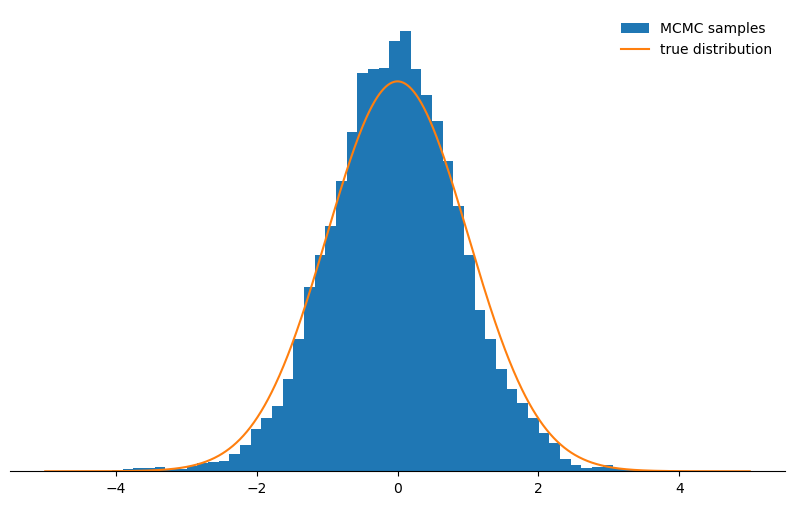

In [43]:
sample_and_display(np.array([2.0]), 0.1, 500000, 25000, log_prob)

Sloooowly getting there...

## Conclusions

With these considerations, I conclude the first blog post of this series.
I hope you now understand the intuition behind the Metropolis-Hastings algorithm, its parameters and why it is an extremely useful tool to sample from non-standard probability distributions you might encounter out there in the wild.  

I highly encourage you to play around with the code in this notebook - this way, you can learn how the algorithm behaves in various circumstances and deepen your understanding of it.
Go ahead and try out a non-symmetric proposal distribution!
What happens if you don't adjust the acceptance criterion accordingly?
What happens if you try to sample from a bimodal distribution?
Can you think of a way to automatically tune the stepsize?
What are pitfalls here?
Try out and discover yourself!  

In my next post, I will discuss the Gibbs sampler - a special case of the Metropolis-Hastings algorithm that allows you to approximately sample from a multivariate distribution by sampling from the conditional distributions.

Thanks for reading&mdash;go forward and sample!

# Introduction to MCMC, part II: Hamiltonian Monte Carlo

This is the secdond post of a series of blog posts about Markov Chain Monte Carlo (MCMC) techniques:

- [Part I: Metropolis-Hastings](https://www.tweag.io/posts/2019-10-25-mcmc-intro1.html)

So far, we discussed the Metropolis-Hastings algorithm.
This algorithm can produce highly correlated samples&mdash;Metropolis-Hastings has a pronounced random walk behaviour
In this blog post, we will take advantage of an additional piece of information about a distribution&mdash;its shape&mdash;and learn about Hamiltonian Monte Carlo, an algorithm [whose roots are in quantum physics](https://doi.org/10.1016%2F0370-2693%2887%2991197-X).

As always, you can [download the corresponding IPython notebook](https://github.com/tweag/blog-resources/blob/master/mcmc-intro/mcmc_introduction.ipynb) and play around with the code to your heart's desire!

## Physical intuition
As mentioned above, when doing Metropolis-Hastings sampling with a naive proposal distribution, we are essentially performing a random walk without taking into account any additional information we may have about the distribution we want to sample from. 
We can do better!<br>
If the density function we want to sample from is differentiable, we have access to its local shape through its *derivative*.
This derivative tells us, at each point $x$, how the value of the density $p(x)$ increases or decreases depending on how we change the $x$.
That means we should be able to use the derivative of $p(x)$ to propose states with high probabilities&mdash;which is exactly the key idea of Hamiltonian Monte Carlo (HMC).

The intuition behind HMC is that we can interpret a random walker as a particle moving under the effect of *forces* attracting it to higher-probability zones.
That is easier to see with an example: in the next image we show both a probability density $p(x)$ and its corresponding negative log-density $-\log p(x)$, which we will call the *potential energy* $E(x)$:

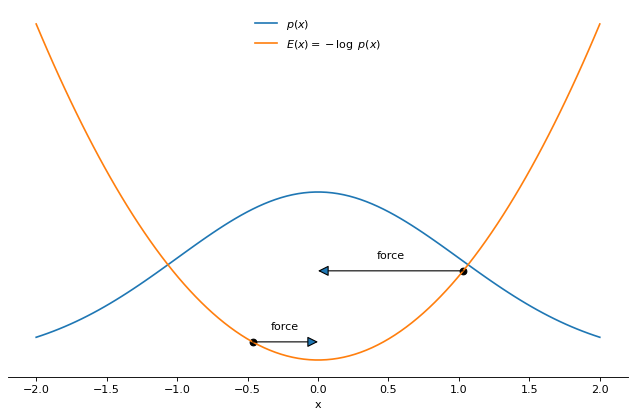

In [47]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

xspace = np.linspace(-2, 2, 100)
unnormalized_probs = np.exp(-0.5 * xspace ** 2)
energies = 0.5 * xspace ** 2

fig, ax = plt.subplots(dpi=80)
ax.plot(xspace, unnormalized_probs, label=r"$p(x)$")
ax.plot(xspace, energies, label=r"$E(x)=-\log\ p(x)$")
prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
x_index1 = 75
ax.scatter((xspace[x_index1],), (energies[x_index1],), color="k")
a_start1 = np.array((xspace[x_index1], energies[x_index1]))
a_end1 = np.array((xspace[x_index1] - xspace[x_index1], energies[x_index1]))
ax.annotate("",a_end1, a_start1, arrowprops=prop)
text_pos1 = (a_start1[0] + 0.5 * (a_end1[0] - a_start1[0]), a_end1[1] + 0.075)
ax.text(*text_pos1, r"force", horizontalalignment="center")

x_index2 = 38
ax.scatter((xspace[x_index2],), (energies[x_index2],), color="k")
a_start2 = np.array((xspace[x_index2], energies[x_index2]))
a_end2 = np.array((xspace[x_index2] - xspace[x_index2], energies[x_index2]))
ax.annotate("",a_end2, a_start2, arrowprops=prop)
text_pos2 = (a_start2[0] + 0.5 * (a_end2[0] - a_start2[0]), a_end2[1] + 0.075, )
ax.text(*text_pos2, r"force", horizontalalignment="center")

ax.set_xlabel("x")
ax.set_yticks(())
for spine in ('top', 'right', 'left'):
    ax.spines[spine].set_visible(False)
ax.legend(frameon=False)
plt.show()

As you can see, the potential energy $E(x)$ looks like a mountainous landscape that attracts the particle (shown at two different positions) to its bottom&mdash;the steeper the landscape, the stronger will be the force pulling it towards the bottom.
What's more, the bottom of this landscape coincides with the region with the largest probability of $p(x)$!
That means that if we are able to predict where the particle will move to given its position and velocity, we can use the result of that prediction as a proposal state for a fancy version of Metropolis-Hastings.

This kind of prediction problem is very common and well-studied in physics&mdash;think of simulating the movement of planets around the sun, which is determined by gravitational forces.
We can thus borrow the well-known theory and methods from classical ("Hamiltonian") mechanics to implement our method!

While HMC is quite easy to implement, the theory behind it is actually far from trivial.
We will skip a lot of detail, but provide additional information on physics and numerics in detailed footnotes.

## The HMC algorithm

In physics, the force acting on a particle can be calculated as the derivative (or gradient) of a _potential energy_ $E(x)$. As said above, the negative log-density will play the role of that potential energy for us:
$$
E(x)=-\log p(x)
$$
Our particle does not only have a potential energy, but also a *kinetic* energy, which is the energy stored in its movement.
The kinetic energy depends on the particle's momentum&mdash;the product of its mass and velocity.
Since in HMC, the mass is often set to one, we will denote the momentum with the letter $v$ (for velocity), meaning that the kinetic energy is defined as$^1$

$$
K(v)=\frac{|v|^2}{2} \mathrm .
$$

Just as the position $x$, the momentum $v$ is generally a vector, whose length is denoted by $|v|$.
With these ingredients in place, we can then define the total energy of the particle as

$$
H(x,v)=K(v)+E(x) \mathrm .
$$

In classical physics, this quantity completely determines the movement of a particle.

HMC introduces the momentum of the particle as an auxiliary variable and samples the joint distribution of the particle's position and momentum.
Under some assumptions$^2$, this joint distribution is given by

$$
\begin{aligned}
p(x,v) &\propto \exp\{-H(x,v)\} \\ 
&= \exp\{-K(v)\} \times \exp\{-E(x)\} \\
&= \exp\left\{-\frac{|v|^2}{2}\right\} \times p(x)\mathrm .
\end{aligned}
$$

We can sample from $p(x,v)$ efficiently by means of an involved Metropolis-Hastings method:
starting from a current state $x$, we draw a random initial momentum $v$$^3$ (that "3" is a footnote) from a normal distribution and simulate the movement of the particle for some time to obtain a proposal state $x^*$.

When the simulation stops, the fictive particle has some position $x^*$ and some momentum $v^*$, which serve as our proposal states.
If we had a perfectly accurate simulation, the total energy $H(x,v)$ would remain the same and the final position would be a perfectly fine sample from the joint distribution.
Unfortunately, all numerical simulation is only approximative, and we have to account for errors.
As we have done before in the original Metropolis-Hastings algorithm, we can correct for the bias with a Metropolis criterion.$^4$
In our case, the acceptance probability is given by

$$
p_\mathrm{acc}^\mathrm{HMC} = \min\left\{1, \exp\{-[H(x^*, v^*) - H(x, v)]\} \right\} \mathrm .
$$

We are not interested in the momentum $v^*$: if the move is accepted, we only store the position $x^*$ as the next state of the Markov chain.

### Implementation
In terms of implementation, the only part of HMC that is not immediately obvious is the simulation of the particle's movement.
The simulation of the movement of the particle works by discretizing time into steps of a certain size.
Position and momentum of a particle are then updated in an alternating fashion.
In HMC, this is usually done as follows$^5$:

In [48]:
def leapfrog(x, v, gradient, timestep, trajectory_length):
    """
    args:
        x: current position
        v: current velocity
        gradient: function that returns the gradient at a given position
        timestep: size of the timestep
        trajectory_length: number of leapfrog steps

    returns:
        new position and new velocity
    """

    # make a half step for momentum at the beginning
    v -= 0.5 * timestep * gradient(x)
    for _ in range(trajectory_length - 1):
        x += timestep * v   # full step for position
        v -= timestep * gradient(x) # full step for velocity
    x += timestep * v
    # make a half step for momentum at the end, so that the step is completed for velocity
    v -= 0.5 * timestep * gradient(x)

    return x, v

Now we already have all we need to proceed to the implementation of HMC!
Here it is:

In [49]:
def sample_HMC(x_old, log_prob, log_prob_gradient, timestep, trajectory_length):
    # switch to physics mode!
    def E(x): return -log_prob(x)
    def gradient(x): return -log_prob_gradient(x)
    def K(v): return 0.5 * np.sum(v ** 2)
    def H(x, v): return K(v) + E(x)

    # Metropolis acceptance probability, implemented in "logarithmic space"
    # for numerical stability:
    def log_p_acc(x_new, v_new, x_old, v_old):
        return min(0, -(H(x_new, v_new) - H(x_old, v_old)))

    # give a random kick to particle by drawing its momentum from p(v)
    v_old = np.random.normal(size=x_old.shape)

    # approximately calculate position x_new and momentum v_new after
    # time trajectory_length  * timestep
    x_new, v_new = leapfrog(x_old.copy(), v_old.copy(), gradient, 
                            timestep, trajectory_length)

    # accept / reject based on Metropolis criterion
    accept = np.log(np.random.random()) < log_p_acc(x_new, v_new, x_old, v_old)

    # we consider only the position x (meaning, we marginalize out v)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

And, analogously to the other MCMC algorithms we discussed before, here's a function to build up a Markov chain using HMC transitions:

In [50]:
def build_HMC_chain(init, timestep, trajectory_length, n_total, log_prob, gradient):
    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_HMC(chain[-1].copy(), log_prob, gradient,
                                   timestep, trajectory_length)
        chain.append(state)
        n_accepted += accept

    acceptance_rate = n_accepted / float(n_total)

    return chain, acceptance_rate

As an example, let's consider a two-dimensional Gaussian distribution.
Here is its log-probability, neglecting the normalization constant:

In [51]:
def log_prob(x): return -0.5 * np.sum(x ** 2)

Now we need to calculate the gradient of the log-probability. 
Its $i$-th component is given by $\frac{\partial}{\partial x^i} E(x)$, where $x^i$ is the $i$-th component of the variable vector $x$.
Doing the math, you'll end up with:

In [52]:
def log_prob_gradient(x): return -x

Now we're ready to test the HMC sampler:

In [53]:
chain, acceptance_rate = build_HMC_chain(np.array([5.0, 1.0]), 1.5, 10, 10000,
                                         log_prob, log_prob_gradient)
print("Acceptance rate: {:.3f}".format(acceptance_rate))


Acceptance rate: 0.622


In [55]:
def plot_samples_2D(chain, path_length, burnin, ax, xlims=(-3, 3), ylims=(-0.5, 0.5)):
    chain = np.array(chain)
    bins = [np.linspace(xlims[0], xlims[1], 100), np.linspace(ylims[0], ylims[1], 100)]
    ax.hist2d(*chain[burnin:].T, bins=bins)
    ax.plot(*chain[:path_length].T, marker='o', c='w', lw=0.4, 
            markersize=1, alpha=0.75)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])

To display the result, we plot a two-dimensional histogram of the sampled states and the first 200 states of the chain:

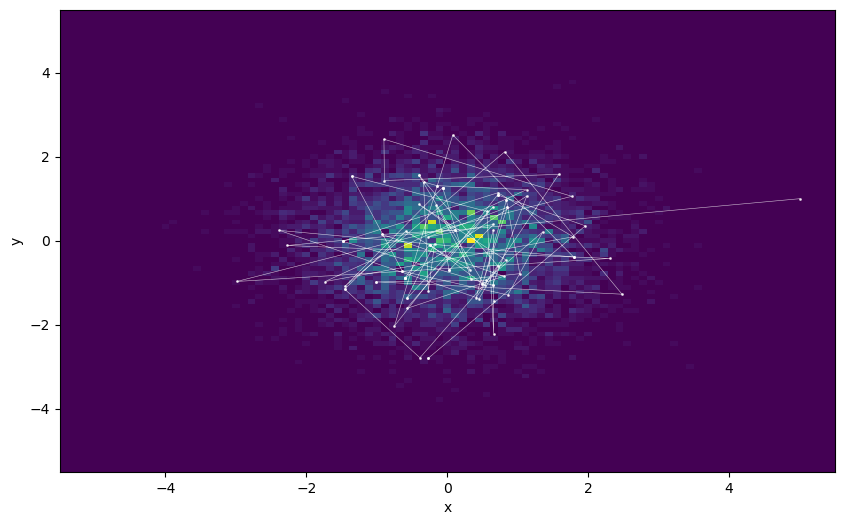

In [57]:
fig, ax = plt.subplots(dpi=100)
plot_samples_2D(chain, 100, 200, ax, xlims=(-5.5, 5.5), ylims=(-5.5, 5.5))
plt.show()

We see that the HMC states are indeed quite far away from each other&mdash;the Markov chain jumps relatively large distances.

How does Metropolis-Hastings do on the same distribution?
Let's have a look and run a Metropolis-Hastings sampler with the same initial state and a stepsize chosen such that a similar acceptance rate is achieved.

In [58]:
chain, acceptance_rate = build_MH_chain(np.array([5.0, 1.0]), 2.6, 10000, log_prob)
print("Acceptance rate: {:.3f}".format(acceptance_rate))

Acceptance rate: 0.623


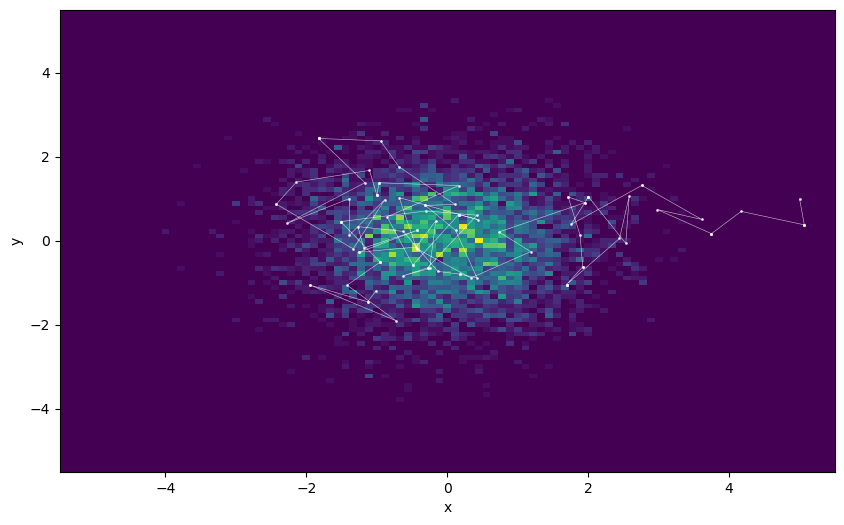

In [60]:
fig, ax = plt.subplots(dpi=100)
plot_samples_2D(chain, 100, 200, ax, xlims=(-5.5, 5.5), ylims=(-5.5, 5.5))
plt.show()

What you see is that Metropolis-Hastings takes a much longer time to actually find the relevant region of high probability and then explore it.
This means that, with a similar acceptance rate, HMC produces much less correlated samples and thus will need fewer steps to achieve the same sampling quality.


While this advantage is even more pronounced in higher dimensions, it doesn't come for free:
numerically approximating the equations of motions of our fictive particle takes up quite some computing power, especially if evaluating the log-probability gradient is expensive.

### Choosing the parameters
Two parameters effectively determine the distance of the proposal state to the current state: the integration time step and the number of steps to perform.<br>
Given a constant number of steps, the larger the integration time step, the further away from the current state the proposal will be.
But at the same time, larger time steps implies less accurate results, which means lower acceptance probabilities.<br>
The number of steps has a different impact:
given a fixed step size, the more steps performed, the less correlated the proposal will be to the current state.
There is a risk of the trajectory doubling back and wasting precious computation time, but
[NUTS](http://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf), a neat variant of HMC which optimizes the number of integration steps, addresses exactly this problem.<br>
For a basic implementation of HMC, one can use a fixed number of integration steps and automatically adapt the timestep, targeting a reasonable acceptance rate (e.g. 50%) during a burn-in period.
The adapted timestep can then be used for the final sampling.

### Drawbacks
Unfortunately, there's no such thing as a free lunch.
While the big advantage of HMC, namely, less correlated samples with high acceptance rates, are even more pronounced in real-world applications than in our toy example, there are also some disadvantages.

First of all, you can only easily use HMC when you have continuous variables since the gradient of the log-probability for non-continuous variables is not defined.
You might still be able to use HMC if you have a mix of discrete and continuous variables by embedding HMC in a [Gibbs sampler](https://www.tweag.io/posts/2020-01-09-mcmc-intro2.html).
Another issue is that the gradient can be very tedious to calculate and its implementation error-prone.
Luckily, popular probabilistic programming packages (see below) which implement HMC as their main sampling workhorse, take advantage of [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), which relieves the user from worrying about gradients.

Finally, as we just discussed, there are quite a few free parameters, the suboptimal tuning of which can severely decrease performance.
However, since HMC is a very popular algorithm, many implementations come with all sorts of useful heuristics to choose parameters, which makes HMC easy to profit from in spite of these drawbacks.

## Conclusion
I hope that at this point, you have a general understanding of the idea behind HMC and both its advantages and disadvantages.
HMC is still subject to active research and if you like what you just read (and have the required math / stats / physics skills), there are many more interesting things to learn.$^6$<br>
To test your understanding of HMC, here's a little brain teaser, which also invites you to play around with the code:
what would happen if you made a mistake in the gradient calculation or implementation?
The answer is: you still get a perfectly valid MCMC algorithm, but acceptance rate will decrease.
But why?

I would also like to point out that there are several great, accessible HMC resources out there. For example, a classic introduction is [MCMC using Hamiltionian dynamics](https://arxiv.org/pdf/1206.1901.pdf) and [these amazing visualizations](https://chi-feng.github.io/mcmc-demo/app.html) explain HMC and the influence of the parameters better than any words.

Whether you now decide to take a deep dive into HMC or you're just content to have finally learned what kind of magic is working under the hood of probabilistic programming packages such as [PyMC3](https://github.com/pymc-devs/pymc3), [Stan](https://mc-stan.org), and [Edward](http://edwardlib.org/)&mdash;stay tuned to not miss the last blog post in this series, which will be about Replica Exchange, a cool strategy to fight issues arising from multimodality!

## Footnotes
1. Although hidden here, in general, the kinetic energy of a physical object involves the mass of the object. It turns out that HMC even permits a different "mass" (measure of inertia) for each dimension, which can even be position-dependent. This can be exploited to tune the algorithm.

2. These assumptions are defined by the [canonical ensemble](https://en.wikipedia.org/wiki/Canonical_ensemble). In statistical mechanics, this defines a large, constant number of particles confined in a constant volume. The whole system is kept at a constant temperature.

3. The temperature of a system is closely related to the average kinetic energy of its constituent particles. Drawing a new momentum for every HMC step can be seen as a kind of thermostat, keeping the average kinetic energy and thus the temperature constant. It should be noted that there are also [HMC variants with only partial momentum refreshment](https://arxiv.org/abs/1205.1939), meaning that the previous momentum is retained, but with some additional randomness on top.

4. HMC combines two very different techniques, both very popular in computational physics: Metropolis-Hastings, which, in a sense, circumvents a real simulation of the physical system, and molecular dynamics, which explicitly solves equations of motion and thus simulates the system. Because of this, HMC is also known as (and was originally named) Hybrid Monte Carlo.

5. The movement of a classical particle follows a set of differential equations known as [Hamilton's equations of motion](https://en.wikipedia.org/wiki/Hamiltonian_mechanics). In the context of HMC, numerical methods to solve them have to maintain crucial properties of Hamiltonian mechanics: _reversibility_ assures that a trajectory can be run "backwards" by flipping the direction of the final momentum and is important for detailed balance. [_Volume conservation_](https://en.wikipedia.org/wiki/Liouville%27s_theorem_(Hamiltonian)) essentially keeps the acceptance criterion simple. In addition, [_symplecticity_](https://en.wikipedia.org/wiki/Symplectic_integrator) is highly advantageous: it implies volume conservation, but also guarantees that the energy error stays small and thus leads to high acceptance rates. We use [leapfrog integration](https://en.wikipedia.org/wiki/Leapfrog_integration), which  checks all these boxes and is the standard method used in HMC.

6. How about [using differential geometry to continuously optimize the mass](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9868.2010.00765.x) or [viewing HMC in terms of operators acting on a discrete state space ladder](https://arxiv.org/abs/1409.5191)?
